# Cross entropy and maximum likelihood


In this notebook, I'll try to explain how to deal with count data in deep learning and how to implement in Python using [TensorFlow](http://tensorflow.org). Before going into details of count data modelling, let's first remember the link between the loss functions and maximum likelihood estimates.

## Binary classification

For classification problems, a commonly used loss (error) function in deep learning is [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy):

$$ H(p,q)=-\sum_x p(x)\log q(x) $$

where $p$ and $q$ represents data and model distributions respectively and the aim is to make the model distribution $q$ (our predictions) as close as possible to $p$ (labels of the data) in terms of cross entropy. Therefore this quantity is minimized.

If the task is binary classification, then it's called binary cross entropy (BCE) which looks like: 

$$ \text{BCE}(y,\hat{y})=-y\log\hat{y} - (1-y)\log(1-\hat{y})$$

where $y$ and $\hat{y}$ represent the ground truth (data distribution) and our prediction (model distribution), respectively. To see that it is actually the negative log likelihood of [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), let's have a closer look at Bernoulli. Likelihood function of Bernoulli is given below

$$ L_{bernoulli}(x;p) = \begin{cases}
                            p   & \text{if } x = 1, \\
                            1-p & \text{if } x = 0.
                        \end{cases}
$$

$p$ here, in the interval $[0-1]$, is the only parameter of Bernoulli, which also corresponds to the mean of the distributon. Same likelihood function can also be expressed as 

$$ L_{bernoulli}(x;p) = p^x + (1-p)^{(1-x)}$$ 

whereas the negative log likelihood can be written as

$$ NLL_{bernoulli}(x; p) = -x\log p - (1-x)\log(1-p) $$

Here we, unsurprisingly, ended up with binary cross entropy and showed that binary cross entropy loss function used in deep learning is basically MLE of Bernoulli. (It is trivial to extend this to categorical cross entropy for multiclass problems. For regression and the link between the mean squared error function and MLE of Normal distribution, see chapter 5.5.2 in the [deep learning book](http://www.deeplearningbook.org/contents/ml.html).)

In logistic regression (and deep learning for binary classification), we try to find the maximum of conditional likelihood, meaning that we estimate the mean parameter of Bernoulli ($p$) given data $X$: 

$$ \text{arg}\max\limits_{W}\,\sum_i y_i\log f(x_i,W) + (1-y_i)\log(1-f(x_i, W))  $$

where

$$f(x_i, W) = \text{sigmoid}(W\cdot x_i)$$

in a linear model. Sigmoid function here, which converts the linear transformation of the data into the mean of the distribution, is referred to as the *inverse [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function)* in generalized linear model (GLM) literature and stats community whereas it is called the *activation function* in the neural network community. We can formulate $f$ as a n-layer feed-forward neural network as follows:

$$f(X, W) = g_n(... (g_2(g_1(X, W_1), W_2))..., W_n)$$

where $g_n$ is sigmoid (bias terms are avoided for brevity). We can now generalize loss functions via formulations of MLEs: 

$$ \hat{W} = \text{arg}\max\limits_{W}\, P(Y|X, W)$$

Now let's explore how to model the count data using other discrete probability distributions such as Possion or negative binomial.

## Loss functions for count data 

### Poisson case

Now let's imagine that our labels, which were binary in previous case, can only take non-negative integer values ${0,1,2,...}$. Although, this might look similar to classification labels where we again have integer values, in this case there is no fixed upper bound and the variable is ordinal so that the distance between $1$ and $3$, and $1$ and $2$ are not the same as we have in categorical data e.g. one-hot encoded class labels. 

This type of data, called [count data](https://en.wikipedia.org/wiki/Count_data), can be generated through a process where the number of occurences of an event, is counted. If the interval where we count the occurences is fixed, then this process is called the Possion process and the data can be modelled using the [Possion distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Now we can derive the loss function based on the Possion distribution, instead of Bernoulli:

$$ L_{poisson}(x;\lambda) = \frac{\lambda^x \exp(-\lambda)}{x!}$$

where the only parameter $\lambda$ represents both the mean and the variance of the distribution. The negative log likelihood is:

$$ NLL_{poisson}(x;\lambda) = \lambda - x\log{\lambda}+ \log(x!)$$

For the maximizing the conditional likelihood, we can now define the minimization of negative log likelihood as

$$ \text{arg}\min\limits_{W}\,\sum_i f(x_i, W) - y\log{f(x_i, W)} $$

where we estimate the $\lambda$ parameter of Possion conditioned on data $X$ and our parameters $W$.

Now, the only missing ingredient is the correct activation function which was sigmoid in Bernoulli case. The exponential function (which corresponds to log link function) is the classical one used in Possion regression, which makes sense since it brings the range from ($-\infty,\infty$) to ($0, \infty$).

We can implement the loss function and test it simply by finding MLE of generated toy data and comparing it to sample mean which is an unbiased MLE of Possion mean parameter:

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
%matplotlib inline
np.random.seed(42)

# In the implementations, I try to keep the function signature
# similar to those of Keras objective functions so that
# later on we can use them in Keras smoothly:
# https://github.com/fchollet/keras/blob/master/keras/objectives.py#L7
def poisson_loss(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    # we can use the Possion PMF from TensorFlow as well
    # dist = tf.contrib.distributions
    # return -tf.reduce_mean(dist.Poisson(y_pred).log_pmf(y_true))
    
    # last term can be avoided since it doesn't depend on y_pred
    # however keeping it gives a nice lower bound to zero
    return tf.reduce_mean(y_pred - y_true*tf.log(y_pred+1e-10) + \
                          tf.lgamma(y_true+1.0))

# Apparently this is already implemented in Keras:
# https://github.com/fchollet/keras/blob/master/keras/objectives.py

Let's draw samples from Poisson:

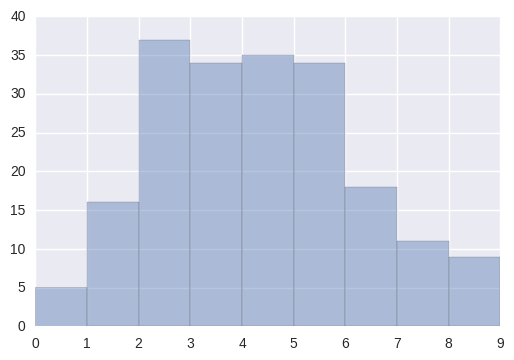

In [2]:
# true Poisson mean parameter
poisson_mean = 4
poisson_numsample = 200

# Poisson sampling is still not implemented in TF
samples = np.random.poisson(poisson_mean, poisson_numsample)
_ = sns.distplot(samples, kde=False, bins=range(max(samples)))

Here we generated samples from a Poisson with $\lambda=4$. Now we will estimate the mean using gradient descent in TensorFlow.

In [3]:
# random poisson mean parameter
param = tf.Variable(tf.random_uniform([1], 0.001, 0.01))

# create the optimizer
optimizer = tf.train.RMSPropOptimizer(0.1)
loss = poisson_loss(samples, param)

# let's minimize neg. log lik.
train_step = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Initial value of mean parameter: {}\n'
          .format(param.eval()))
    for i in range(300): 
        sess.run(train_step)
        if i % 50 == 0: 
            print('--> Step {}, possion loss: {:.4}'
                  .format(i, loss.eval()))
    print('\nEstimated mean: {}'.format(param.eval()[0]))
    print('Sample mean: {}'.format(np.mean(samples)))
    print('True mean: {}'.format(poisson_mean))

Initial value of mean parameter: [ 0.00847053]

--> Step 0, possion loss: 8.1
--> Step 50, possion loss: 4.226
--> Step 100, possion loss: 2.279
--> Step 150, possion loss: 2.092
--> Step 200, possion loss: 2.092
--> Step 250, possion loss: 2.092

Estimated mean: 3.8064117431640625
Sample mean: 3.855
True mean: 4


### Negative binomial case

The major limitation of Poisson distribution is that the mean and variance are equal and are controlled by a single parameter, $\lambda$. This, however, is not realistic in many real world cases. [Negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) (NB) is another discrete distribution which can be used when mean and variance of the data are not equal. Although the classical textbook definition of NB is *the number of successes before a specified number of failures occur in i.i.d Bernoulli trials*, the alternative parameterization with mean ($\mu$) and dispersion ($\theta$) is more intuitive and useful. See these [lecture notes](https://www.unc.edu/courses/2010fall/ecol/563/001/docs/lectures/lecture6.htm) for a nice derivation of this parameterization. Here is the probability mass function according to this parameterization:


$$ L_{nbinom}(x;\mu,\theta) = \frac{\Gamma(x+\theta)}{\Gamma(\theta)\Gamma(x+1)}\left( \frac{\theta}{\theta+\mu}\right)^\theta\left(\frac{\mu}{\theta+\mu}\right)^x$$

where parameters $\mu$ and $\theta$ represent the mean and dispersion. The negative log likelihood is:

$$ NLL_{nbinom}(x;\mu,\theta) = -\log\Gamma(x+\theta)+\log\Gamma(\theta)+\log\Gamma(x+1)-\theta\left(\log\theta-\log(\theta+\mu)\right)-x\left(\log\mu-\log(\theta+\mu)\right)$$

Note that, this reduces to Poisson as $\theta\to\infty$. Here we will use $\theta^{-1}$ as the dispersion parameter since it is more convenient e.g. we can initialize $\theta^{-1}$ to $0$. We can now implement NB loss in Tensorflow:

In [4]:
# We need a class (or closure) here,
# because it's not possible to
# pass extra arguments to Keras loss functions
# See https://github.com/fchollet/keras/issues/2121

# dispersion (theta) parameter is a scalar by default.
# scale_factor scales the nbinom mean before the 
# calculation of the loss to balance the
# learning rates of theta and network weights

class NB(object):
    def __init__(self, theta=None, theta_init=[0.0],
                 scale_factor=1.0,
                 debug=False, **theta_kwargs):
        
        # for numerical stability
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        
        # a variable may be given by user or it can be created here
        if theta is None:
            theta = tf.Variable(theta_init, dtype=tf.float32,
                                name='theta', **theta_kwargs)

        # to keep dispersion always non-negative
        self.theta = tf.nn.softplus(theta)
           
    def loss(self, y_true, y_pred):
        scale_factor = self.scale_factor
        eps = self.eps
        
        with tf.name_scope("nbinom_loss"):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor
            
            theta = 1/(self.theta+eps)

            t1 = -tf.lgamma(y_true+theta+eps) 
            t2 = tf.lgamma(theta+eps)
            t3 = tf.lgamma(y_true+1.0) 
            t4 = -(theta * (tf.log(theta+eps)))
            t5 = -(y_true * (tf.log(y_pred+eps)))
            t6 = (theta+y_true) * tf.log(theta+y_pred+eps)      

            if self.debug:
                tf.summary.histogram('t1', t1)
                tf.summary.histogram('t2', t2)
                tf.summary.histogram('t3', t3)
                tf.summary.histogram('t4', t4)
                tf.summary.histogram('t5', t5)
                tf.summary.histogram('t6', t6)

            final = tf.reduce_mean(t1 + t2 + t3 + t4 + t5 + t6) 
        return final

Now let's generate random samples from negative binomial using Gamma and Poisson distributions since it also corresponds to a [Poisson-Gamma mixture](https://en.wikipedia.org/wiki/Negative_binomial_distribution#Gamma.E2.80.93Poisson_mixture):

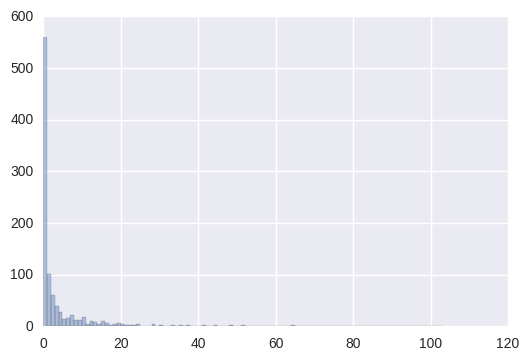

In [5]:
def random_nbinom(mean, disp, n=None):
    eps = 1e-10
    # translate these into gamma parameters
    gamma_shape = 1 / (disp+eps)
    gamma_scale = (mean / (gamma_shape+eps))+eps
    gamma_samples = np.random.gamma(gamma_shape, gamma_scale, n)
    return np.random.poisson(gamma_samples)

nb_mean = 4
nb_disp = 5.5
nb_numsample = 1000
nb_samples = random_nbinom(nb_mean, nb_disp, nb_numsample)
_ = sns.distplot(nb_samples, kde=False, bins=range(max(nb_samples)))

Let's jointly estimate mean and dispersion parameters using batch gradient descent:

In [6]:
# nb mean parameter should be positive
# we can ignore it for now though
param_mu = tf.Variable(tf.random_uniform([1], 0.001, 0.01))
nb = NB()
nbinom_loss, param_theta = nb.loss, nb.theta

optimizer = tf.train.RMSPropOptimizer(0.01)
loss = nbinom_loss(nb_samples, param_mu)

# let's minimize neg. log lik.
train_step = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Initial (random) value of parameter mu: {}'
          .format(param_mu.eval()))
    print('Initial value of parameter theta: {}\n'
          .format(param_theta.eval()))
    for i in range(1000): 
        sess.run(train_step)
        if i % 200 == 0: 
            print('--> Step {}, nbinom loss: {:.4}'
                  .format(i, loss.eval()))

            print('\nEstimated parameter mu: {}'.format(param_mu.eval()))
            
    print('Estimated parameter theta: {}'.format(param_theta.eval()))
    print('Sample mean: {}'.format(np.mean(nb_samples)))
    print('True parameter mu: {}'.format(nb_mean))
    print('True parameter theta: {}'.format(nb_disp))

Initial (random) value of parameter mu: [ 0.00456145]
Initial value of parameter theta: [ 0.69314718]

--> Step 0, nbinom loss: 15.46

Estimated parameter mu: [ 0.03618406]
--> Step 200, nbinom loss: 2.623

Estimated parameter mu: [ 1.32158637]
--> Step 400, nbinom loss: 2.086

Estimated parameter mu: [ 3.03224015]
--> Step 600, nbinom loss: 2.046

Estimated parameter mu: [ 4.27592802]
--> Step 800, nbinom loss: 2.046

Estimated parameter mu: [ 4.27094269]
Estimated parameter theta: [ 5.53212643]
Sample mean: 4.276
True parameter mu: 4
True parameter theta: 5.5


# Multivariate Negative Binomial Regression in Keras

## Generate toy data

Let's generate a toy data with 1000 observations, 10 features (predictors) and 10 response (output) variables:

$$ \textbf{Y} \sim \text{NB}(\exp(\textbf{X}\cdot \textbf{W}), \theta)$$

where $X\in \mathbb{R}^{1000\times10}$ and $W\in\mathbb{R}^{10\times10}$ are randomly generated data and parameter matrices, respectively.

Finally, we sample from negative binomial where the mean is $\exp(\textbf{X}\cdot \textbf{W})$ and the dispersion parameters for response variables are sampled from $\text{Uniform}(0, 2)$.

In [7]:
num_sample = 1000
num_feat = 10
num_out = 10
dispersion = np.random.uniform(0, 2, [1, num_out])

X = np.random.normal(0, 0.5, (num_sample, num_feat)).astype(np.float32)
W = np.random.normal(0, 0.5, (num_feat, num_out)).astype(np.float32)
b = np.random.normal(0, 0.5, (1, num_out)).astype(np.float32)
y_mean = np.exp(np.dot(X, W) + b)
y_disp = np.zeros_like(y_mean) + dispersion

Y = random_nbinom(mean=y_mean, disp=y_disp)
print(Y[:5])

[[ 1  0  1  2  0 15  1  1  3  0]
 [ 1  0  1  0  2  0  0  0  2  2]
 [ 0  0  0  2  2  0  2  2  0  1]
 [ 0  0  1 19  0  0  3  2  2  4]
 [ 4  0  0  4  0  0  2 18  0  0]]


We can use matplotlib to visualize the comparison of true parameters and the estimated ones:

In [8]:
def visualize(x, y, x_label, y_label):
    plt.scatter(x, y)
    plt.plot([min(x), max(x)], [(min(x)), max(x)], "g--") #poor man's abline
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Now let's implement a neural network model in TensorFlow using NB loss function:

INFO:tensorflow:Summary name fc/weights:0 is illegal; using fc/weights_0 instead.
INFO:tensorflow:Summary name fc/biases:0 is illegal; using fc/biases_0 instead.
Step 0 - nbinom loss = 1.707, (0.023 sec/step)
Step 100 - nbinom loss = 1.479, (0.004 sec/step)
Step 200 - nbinom loss = 1.365, (0.004 sec/step)
Step 300 - nbinom loss = 1.362, (0.005 sec/step)
Step 400 - nbinom loss = 1.362, (0.004 sec/step)


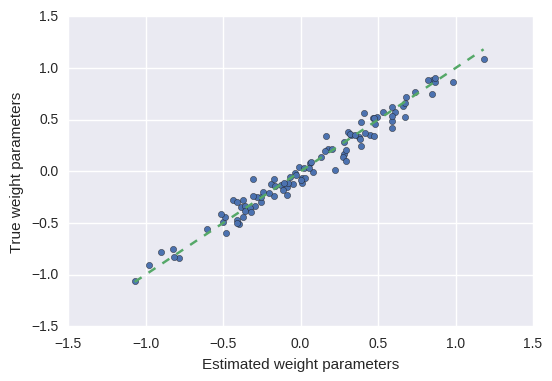

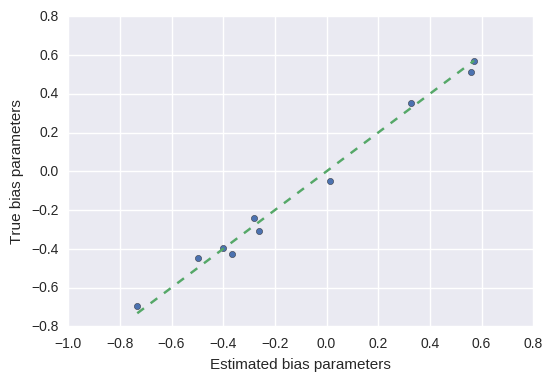

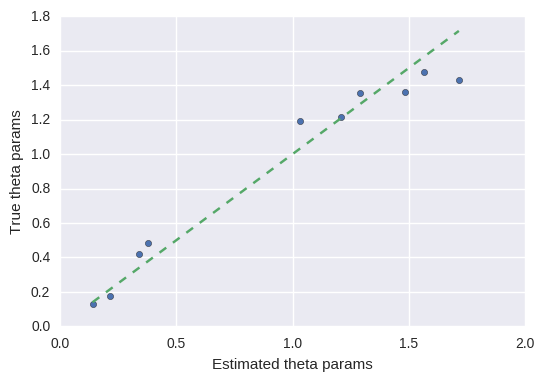

In [9]:
import time
slim = tf.contrib.slim

tf.reset_default_graph()

with tf.Session() as sess:
    predictions = slim.fully_connected(X, num_out,
                                       activation_fn=tf.exp,
                                       scope='fc')
    nb = NB(theta_init=tf.zeros([1, num_out]),
                                       debug=True)
    
    nb_loss, nb_theta = nb.loss, nb.theta
    loss = nb_loss(Y, predictions)
    slim.losses.add_loss(loss)
    tf.summary.scalar('loss', loss)

    optimizer = tf.train.RMSPropOptimizer(1e-2)
    train_op = slim.learning.create_train_op(loss, optimizer)
    
    [tf.summary.histogram(x.name, x) for x in slim.get_model_variables()]
    summary_ops = tf.summary.merge_all()

    sess.run(tf.global_variables_initializer())
    swriter = tf.summary.FileWriter('logs_tf', sess.graph)

    for i in range(500):
        start_time = time.time()
        step_loss, summaries = sess.run([train_op, summary_ops])
        swriter.add_summary(summaries)
        
        duration = time.time() - start_time

        if i % 100 == 0:
            print('Step {:d} - nbinom loss = {:.3f}, ({:.3f} sec/step)'
                  .format(i, step_loss, duration))
    swriter.close()
    
    x = slim.get_variables_by_name('fc/weights')[0].eval().reshape(-1)
    y = W.reshape(-1)
    visualize(x, y, 'Estimated weight parameters', 'True weight parameters')
    
    x = slim.get_variables_by_name('fc/biases')[0].eval().reshape(-1)
    y = b.reshape(-1)
    visualize(x, y, 'Estimated bias parameters', 'True bias parameters')
    
    x = nb_theta.eval().reshape(-1)
    y = dispersion.reshape(-1)
    visualize(x, y, 'Estimated theta params', 'True theta params')

Let's now implement it in Keras:

Using TensorFlow backend.


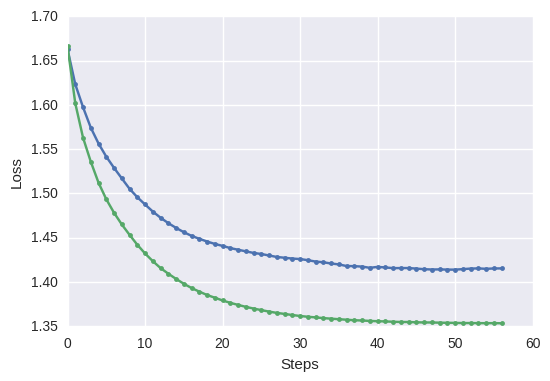

In [10]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop
from keras import backend as K

K.clear_session()

inputs = Input(shape=(num_feat,))
output_layer = Dense(num_out, activation=tf.exp)

# Ugly hack to inject trainable weights to Keras graph
# otherwise theta is not optimized at all
nb_theta = output_layer.add_weight(shape=[num_out],
                                   initializer='zero',
                                   trainable=True)

# Use this new keras-optimizible variable in the loss function
nb = NB(nb_theta)
nb_loss, nb_theta = nb.loss, nb.theta

predictions = output_layer(inputs)
model = Model(input=inputs, output=predictions)

opt = RMSprop(lr=1e-2)
model.compile(optimizer=opt,
              loss=nb_loss) #nbinom loss function

early_stop = EarlyStopping(monitor='val_loss', patience=5)
tb = TensorBoard(log_dir='./logs', histogram_freq=1)

losses = model.fit(X, Y,
                   callbacks=[early_stop, tb],
                   batch_size=256,
                   validation_split=0.2,
                   nb_epoch=5000, verbose=0)

val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

plt.plot(range(len(val_hist)), val_hist, 'b.-',
         range(len(train_hist)), train_hist, 'g.-')
plt.ylabel('Loss')
_ = plt.xlabel('Steps')

Now let's compare true parameters to model parameters:

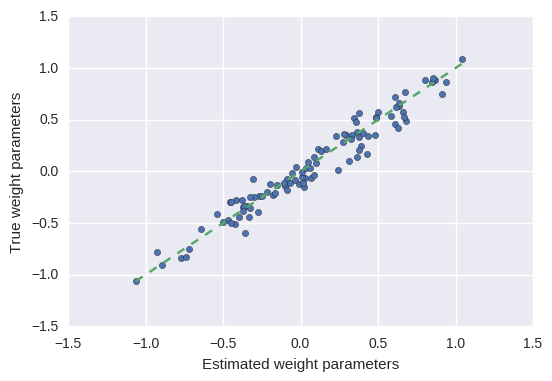

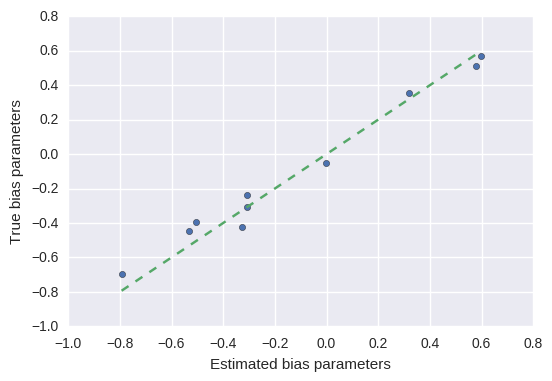

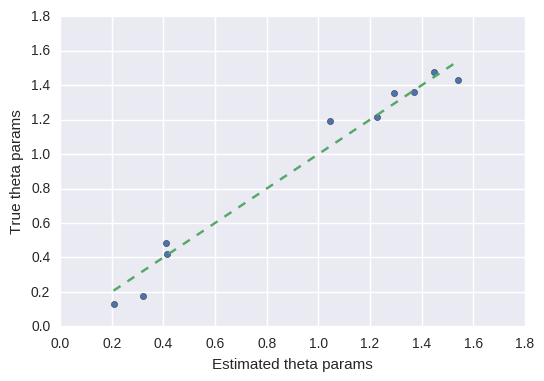

In [11]:
x = K.eval(model.layers[-1].W).reshape(-1)
y = W.reshape(-1)
visualize(x, y, 'Estimated weight parameters', 'True weight parameters')

x = K.eval(model.layers[-1].b).reshape(-1)
y = b.reshape(-1)
visualize(x, y, 'Estimated bias parameters', 'True bias parameters')

x = K.eval(nb_theta)
y = dispersion
visualize(x, y, 'Estimated theta params', 'True theta params')

Go to [Tensorboard](http://localhost:6006) for more fun!